In [1]:
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

import pickle

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
path = '/Users/haohe/Documents/HKUST/competition/data/VisDrone2021-COUNTING/DroneRGBT'
train_images = path + '/Train/RGB'
train_images_TIR = path + '/Train/TIR'
anno = path + '/Train/GT_'
dmap_folder = path + '/Train/DMAP'

Split : train(0:1659),(1659:)

In [21]:
512*0.5, 640*0.5

(256.0, 320.0)

In [129]:
transform = A.Compose(
    [
        #A.RandomSizedCrop(min_max_height=(409, 512), height=409, width=512, p=1.0),
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
        #A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=1.0),
        #A.MaskDropout(1,p=1.)
    ],
    additional_targets={'image': 'image','image1': 'image'}
)

transform_image_only = A.Compose(
    [
        A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
        #A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=1.0),
        A.Blur(blur_limit=3,p=1.),
        A.Normalize(p=1.0,max_pixel_value=1.0),
        ToTensorV2(p=1.0),
    ],
    additional_targets={'image': 'image'}
)

In [22]:

def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(512, 512), height=512, width=640, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            #A.Blur(blur_limit=3,p=0.2),
#             A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            #A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            A.Normalize(p=1.0,max_pixel_value=1.0),
            ToTensorV2(p=1.0),
        ]
#         p=1.0, 
#         bbox_params=A.BboxParams(
#             format='pascal_voc',
#             min_area=0, 
#             min_visibility=0,
#             label_fields=['labels']
#         )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            A.Normalize(p=1.0,max_pixel_value=1.0),
            ToTensorV2(p=1.0),
        ]
#         p=1.0, 
#         bbox_params=A.BboxParams(
#             format='pascal_voc',
#             min_area=0, 
#             min_visibility=0,
#             label_fields=['labels']
#         )
    )

In [58]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(12, 12))

        ax[0].imshow(image)
        ax[1].imshow(mask)
        print(mask.sum())
    else:
        f, ax = plt.subplots(2, 2, figsize=(12, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)
        #print(mask.sum())
        
def get_annotation(xml_datas):
    points = []
    for data in xml_datas['annotation']['object']:
        if data['name']['$'] == 'person':
            if 'point' in data:
                x = data['point']['x']['$']
                y = data['point']['y']['$']
            else:
                x = data['bndbox']['xmin']['$']
                y = data['bndbox']['ymin']['$']
            points.append((x,y))
        else: print(data['name']['$'] +' not a person...')
    return points

def plot_data(img,points,fig_size=(18,12)):
    p_img = img.copy()
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    for point in points:
        cv2.circle(p_img, tuple(point), radius=0,color=(0, 1, 0), thickness=5)
    ax.imshow(p_img)

# Show

In [4]:
def load_image_and_dmap(image_path,dmap_path,fname):
    image = cv2.imread(image_path + fname)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
    image = image/255.
    d_map = np.load(dmap_path + '/' + fname.split('.')[0] + 'Dmap.pkl',allow_pickle=True)
    return image, d_map
    

In [78]:
from xmljson import badgerfish as bf
from xml.etree.ElementTree import fromstring


with open(anno+'/20R.xml','r') as f:
    data = f.read()
    
test_data = bf.data(fromstring(data))
points = get_annotation(test_data)

In [79]:
len(points)

13

In [83]:
with open(anno+'/10R.xml','r') as f:
    data_2 = f.read()
    
test_data_2 = bf.data(fromstring(data_2))
points_2 = get_annotation(test_data_2)

In [84]:
len(points_2)

16

In [85]:
image, d_map = load_image_and_dmap(train_images,dmap_folder,'/20.jpg')
image_2, d_map_2 = load_image_and_dmap(train_images,dmap_folder,'/10.jpg')



In [86]:
imsize = 512
xc,yc = [int(random.uniform(imsize*0.4,imsize*0.6)) for _ in range(2)]
w,h = 640, 512


pos = random.randint(0,1)
if pos == 0: #top left
    x1a,y1a,x2a,y2a = 0,0,xc,yc # img_1
    x1b,y1b,x2b,y2b = w-xc,h-yc,w,h # img_2
elif pos == 1: # top right
    x1a,y1a,x2a,y2a = w-xc,0,w,yc
    x1b,y1b,x2b,y2b = 0,h-yc,xc,h
elif pos == 2: # bottom left
    x1a,y1a,x2a,y2a = 0,h-yc,xc,h
    x1b,y1b,x2b,y2b = w-xc,0,w,yc
elif pos == 3: # bottom right
    x1a,y1a,x2a,y2a = w-xc,h-yc,w,h
    x1b,y1b,x2b,y2b = 0,0,xc,yc

mixup_image = image.copy()
mixup_mask = d_map.copy()
mixup_image[y1a:y2a,x1a:x2a] = image_2[y1b:y2b,x1b:x2b]
mixup_mask[y1a:y2a,x1a:x2a] = d_map_2[y1b:y2b,x1b:x2b]

result_boxes = []
result_boxes.append(points_2)
result_boxes = np.concatenate(result_boxes,0)
padw = x1a-x1b
pady = y1a-y1b

result_boxes[:,0] += padw
result_boxes[:,1] += pady

np.clip(result_boxes[:,0],0,641,out=result_boxes[:,0])
np.clip(result_boxes[:,1],0,513,out=result_boxes[:,1])
result_boxes = result_boxes.astype(np.int32)

result_boxes = result_boxes[np.where(result_boxes[:,0] * result_boxes[:,1] > 0)]
result_boxes = result_boxes[np.where(result_boxes[:,0] < 641)]
result_boxes = result_boxes[np.where(result_boxes[:,1] < 513)]

boxes = []
for (x,y) in points:
    if x >= x1a and x <= x2a and y >= y1a and y <= y2a:
        continue
    else:
        boxes.append((x,y))

mixup_image_points = np.concatenate((boxes, result_boxes),axis=0)
len(mixup_image_points)

14

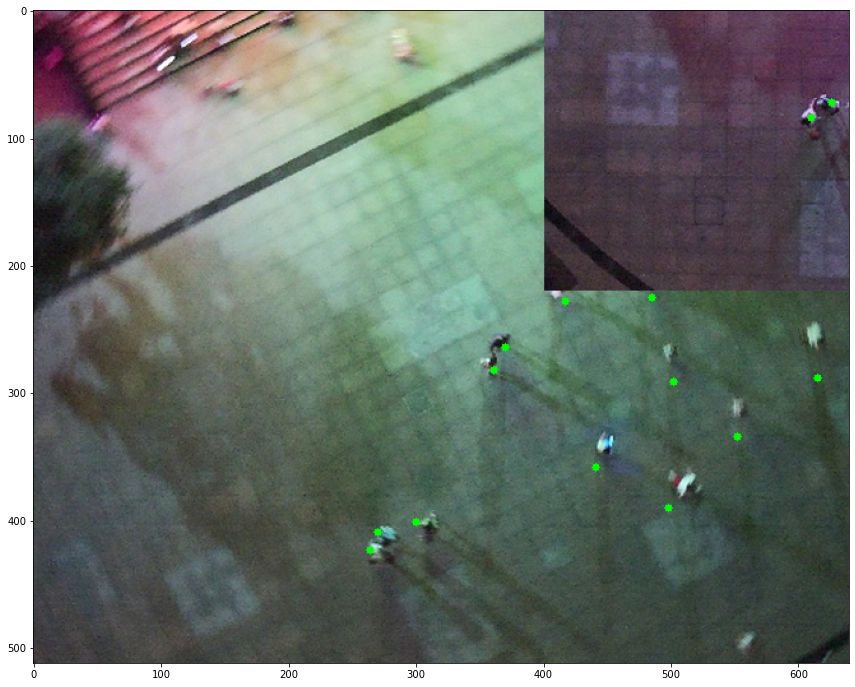

In [87]:
plot_data(mixup_image,mixup_image_points)

13.120423


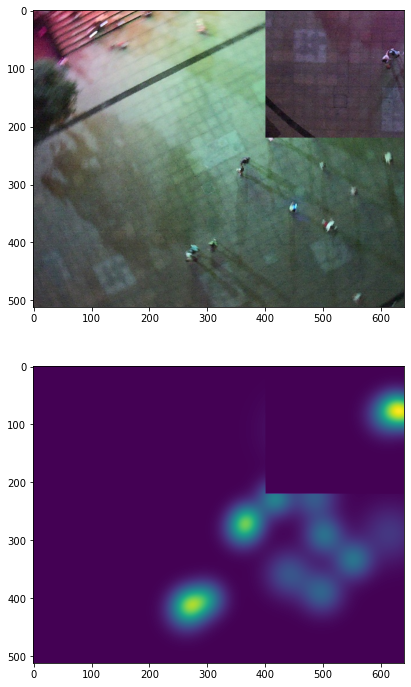

In [88]:
visualize(mixup_image,mixup_mask)

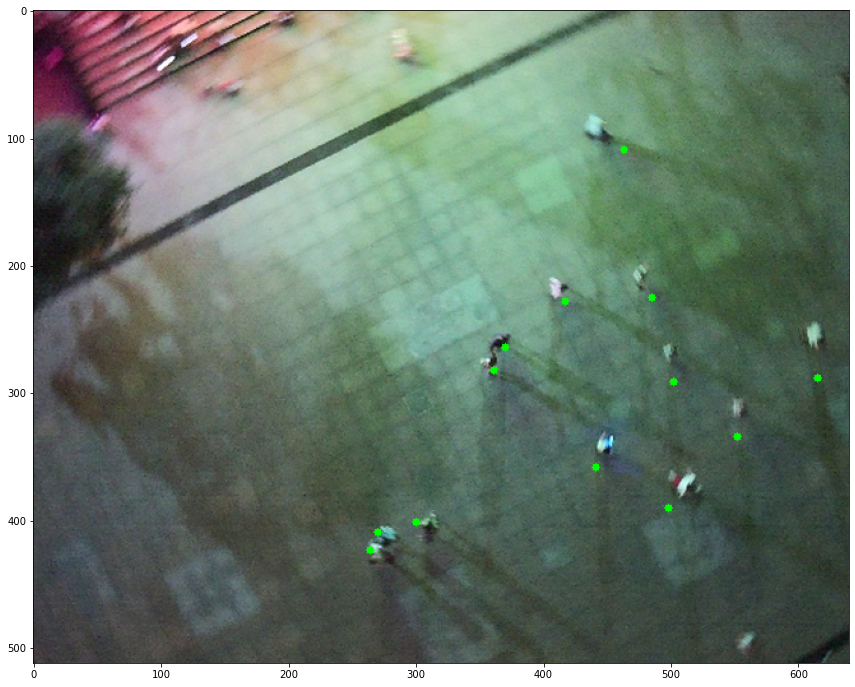

In [89]:
plot_data(image,points)

12.762282


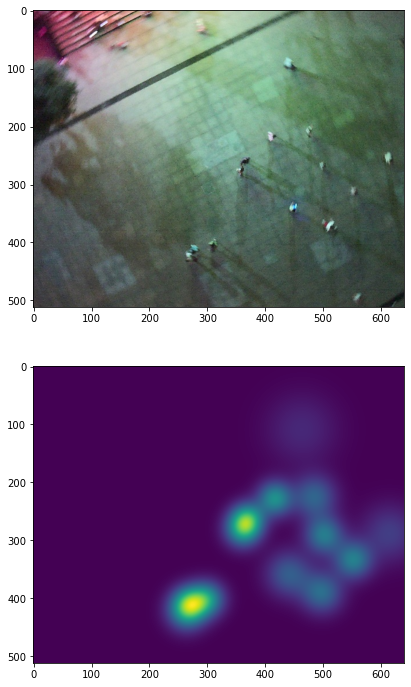

In [82]:
visualize(image,d_map)

15.2031355


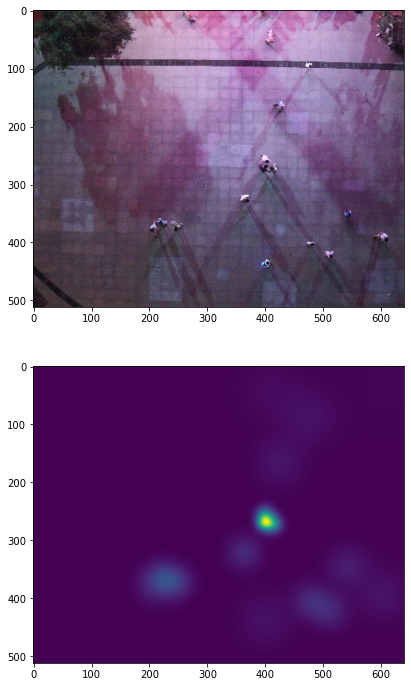

In [66]:
visualize(image_2,d_map_2)

In [20]:
result_boxes = []
result_boxes.append(points_2)
result_boxes = np.concatenate(result_boxes,0)
padw = x1a-x1b
pady = y1a-y1b

result_boxes[:,0] += padw
result_boxes[:,1] += pady

np.clip(result_boxes[:,0],0,641,out=result_boxes[:,0])
np.clip(result_boxes[:,1],0,513,out=result_boxes[:,1])
result_boxes = result_boxes.astype(np.int32)

result_boxes = result_boxes[np.where(result_boxes[:,0] * result_boxes[:,1] > 0)]
result_boxes = result_boxes[np.where(result_boxes[:,0] < 641)]
result_boxes = result_boxes[np.where(result_boxes[:,1] < 513)]

In [17]:
points_2

[(209, 376),
 (225, 364),
 (248, 373),
 (400, 437),
 (478, 404),
 (512, 422),
 (605, 394),
 (542, 345),
 (364, 321),
 (414, 272),
 (399, 270),
 (400, 257),
 (424, 166),
 (614, 35),
 (477, 89),
 (410, 43)]

In [21]:
result_boxes

array([[579,  71],
       [595,  59],
       [618,  68]], dtype=int32)

In [32]:
(x1a,x2a), (y1a,y2a)

((370, 640), (0, 207))

In [39]:
boxes = []
for (x,y) in points:
    if x >= x1a and x <= x2a and y >= y1a and y <= y2a:
        continue
    else:
        boxes.append((x,y))

In [40]:
boxes

[(239, 192),
 (244, 178),
 (264, 196),
 (446, 408),
 (532, 248),
 (573, 251),
 (616, 219),
 (25, 79),
 (635, 479),
 (624, 486),
 (560, 505)]

In [22]:
points

[(239, 192),
 (244, 178),
 (264, 196),
 (446, 408),
 (532, 248),
 (573, 251),
 (616, 219),
 (487, 153),
 (425, 127),
 (411, 115),
 (414, 96),
 (25, 79),
 (635, 479),
 (624, 486),
 (560, 505)]

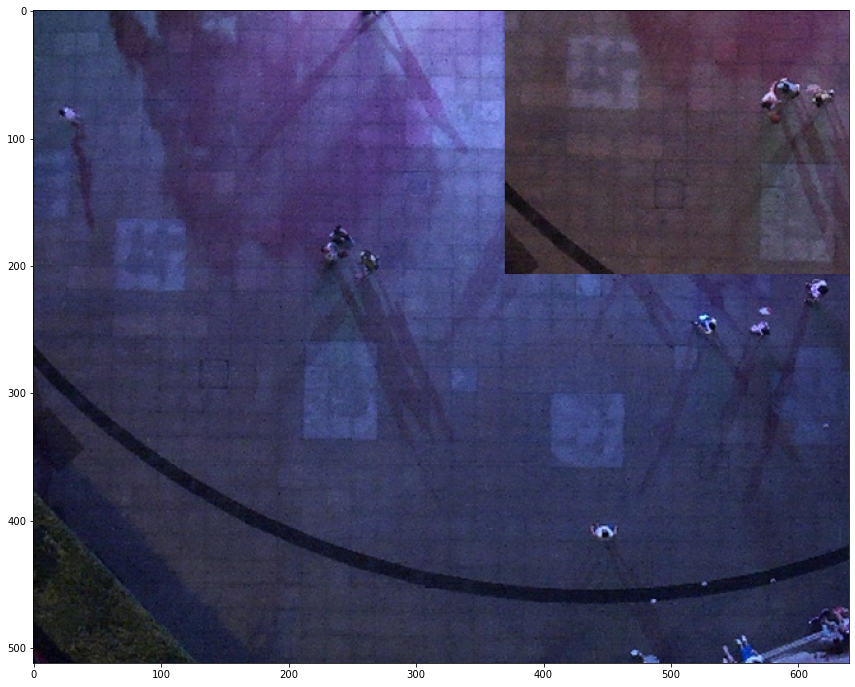

In [11]:
plot_data(mixup_image,mixup_image_points)

11.513028


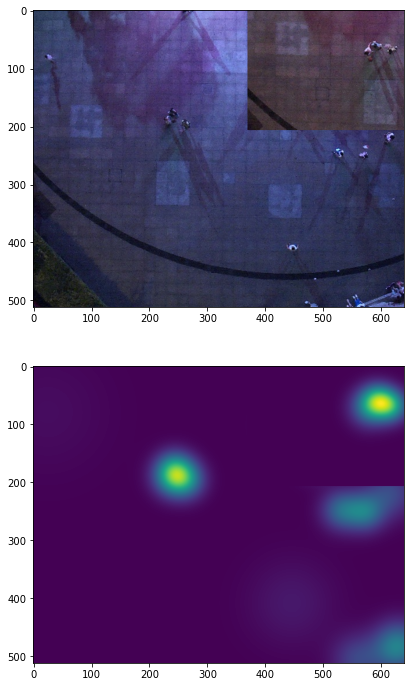

In [12]:
visualize(mixup_image,mixup_mask)

12.967792


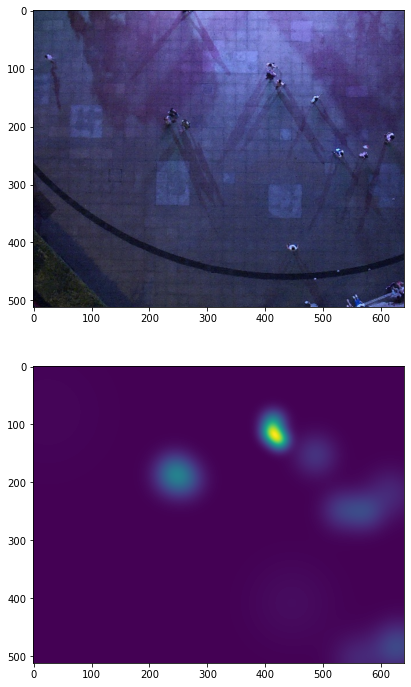

In [160]:
visualize(image,d_map)

15.2031355


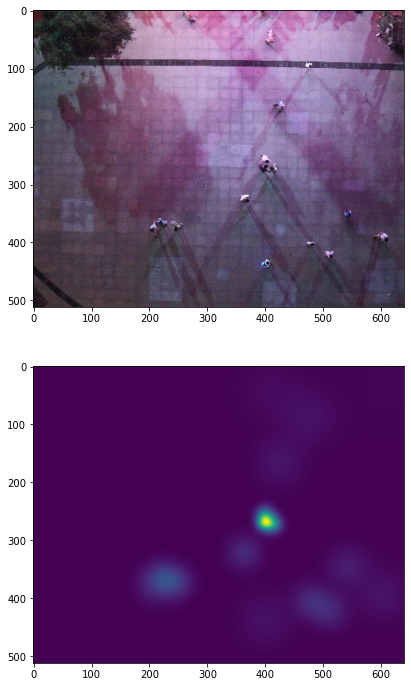

In [164]:
visualize(image_2,d_map_2)

In [130]:
augmented = transform(image=image,image1=d_map)
augmented_image = transform_image_only(image=augmented['image'],mask=augmented['image1'])

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

new_image = augmented_image['image'] * std[...,None,None] + mean[...,None,None]
new_image = new_image.permute(1,2,0).cpu().numpy()
#new_mask = augmented['mask'] * std[...,None,None] + mean[...,None,None]


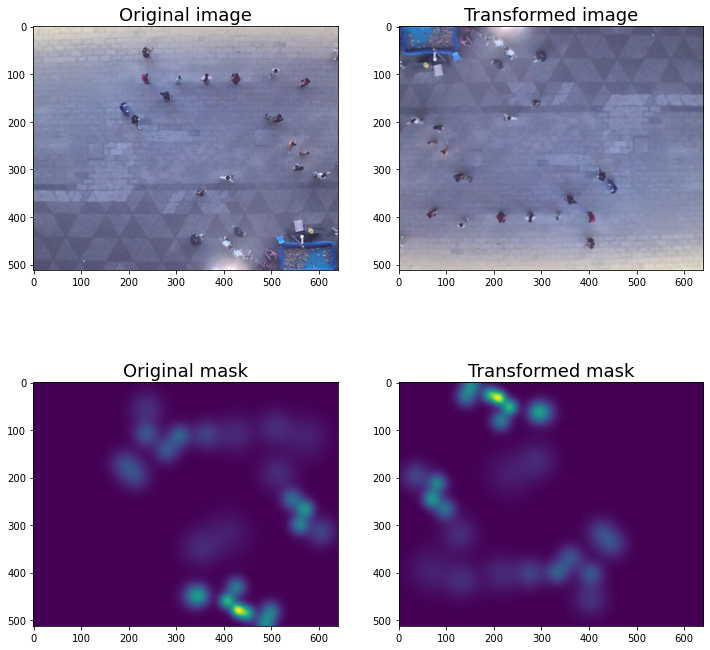

In [131]:
visualize(new_image,augmented_image['mask'],image,d_map)

In [132]:
augmented_image['mask'].sum()

tensor(24.5390)

In [154]:
d_map.sum()

29.933424

In [80]:
new_image.shape

(512, 512, 3)